In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

from transformers import TFAutoModel, AutoTokenizer, GPT2LMHeadModel, GPT2TokenizerFast
import re

In [ ]:
!pip install transformers==4.43.3

In [ ]:
train_df = pd.read_csv("/content/train_df_features.csv")
test_df = pd.read_csv("/content/test_df_features.csv")

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['topic_clean'] = train_df['topic'].apply(clean_text)
train_df['answer_clean'] = train_df['answer'].apply(clean_text)
test_df['topic_clean'] = test_df['topic'].apply(clean_text)
test_df['answer_clean'] = test_df['answer'].apply(clean_text)

In [ ]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True)

# 🔧 Fix: Add a PAD token if missing
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    bert_model.resize_token_embeddings(len(tokenizer))

def get_embedding_batch(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='tf', truncation=True, padding=True)
        outputs = bert_model(**inputs)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding
        embeddings.append(cls_emb.numpy())
    return np.vstack(embeddings)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Al

In [ ]:
topic_embeddings = get_embedding_batch(train_df['topic_clean'].tolist())
# answer_embeddings = get_embedding_batch(train_df['answer_clean'].tolist())

# Convert to list of arrays (optional, ensures compatibility)
topic_embeddings = list(topic_embeddings)
# answer_embeddings = list(answer_embeddings)

# 2️⃣ Save embeddings as .npy files
np.save("topic_emb.npy", np.array(topic_embeddings))
# np.save("answer_emb.npy", np.array(answer_embeddings))

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [ ]:
topic_embeddings = get_embedding_batch(test_df['topic_clean'].tolist())
answer_embeddings = get_embedding_batch(test_df['answer_clean'].tolist())

# Convert to list of arrays (optional, ensures compatibility)
topic_embeddings = list(topic_embeddings)
answer_embeddings = list(answer_embeddings)

# 2️⃣ Save embeddings as .npy files
np.save("test_topic_emb.npy", np.array(topic_embeddings))
np.save("test_answer_emb.npy", np.array(answer_embeddings))

In [ ]:
train_df.head()

,id,topic,answer,is_cheating,topic_clean,answer_clean,topic_emb,answer_emb,num_words,num_chars,...,stopword_ratio,noun_ratio,verb_ratio,adj_ratio,flesch_score,fog_index,topic_answer_similarity,perplexity,punct_ratio,hapax_ratio
0,scr_cd3edac7d322,A girl wakes from a dream and she is not sure ...,"My eyes flew open, and the air around me feels...",1,a girl wakes from a dream and she is not sure ...,my eyes flew open and the air around me feels ...,[-1.10499531e-01 -2.74868041e-01 7.85701871e-...,[-3.35067481e-01 2.63594836e-03 4.64304268e-...,185,844,...,0.540541,0.183784,0.129730,0.070270,-77.378852,73.200000,0.743918,54.248215,0,0.469945
1,scr_86f1104afb28,A journalistic review piece about the top 6 ai...,Robot Butlers in the year of 2025. What are th...,0,a journalistic review piece about the top 6 ai...,robot butlers in the year of 2025 what are the...,[-4.10217702e-01 -1.60288364e-01 -1.08513623e-...,[-4.46920455e-01 -2.87544847e-01 6.05489910e-...,60,306,...,0.583333,0.200000,0.116667,0.066667,38.147143,26.469841,0.753452,64.631088,0,0.444444
2,scr_c461dafbe886,The influence of fictional universities in cam...,"In recent years, apparel featuring the names a...",1,the influence of fictional universities in cam...,in recent years apparel featuring the names an...,[-1.01181582e-01 1.05723776e-01 -7.81796396e-...,[-8.70736688e-02 3.02743375e-01 1.31080881e-...,150,1062,...,0.313333,0.380000,0.126667,0.146667,-119.127000,72.800000,0.648985,103.202835,0,0.646667
3,scr_64880cce429f,Why do girls love horses,"The moment before I hit the dirt, I thought we...",0,why do girls love horses,the moment before i hit the dirt i thought wel...,[-1.26304686e-01 3.73575002e-01 -4.13283557e-...,[-2.90561587e-01 -3.11987489e-01 1.11929849e-...,588,2791,...,0.525510,0.132653,0.185374,0.039116,-476.264148,228.373286,0.675027,59.502541,0,0.328647
4,scr_c7742a3b2444,"Every year, a remote mountain town elects a ne...","In the valley of Eldermist, were the mountains...",1,every year a remote mountain town elects a new...,in the valley of eldermist were the mountains ...,[-3.69460404e-01 2.00119674e-01 1.90144062e-...,[-4.14484799e-01 2.19268873e-01 -2.60837406e-...,154,830,...,0.461039,0.298701,0.136364,0.032468,-62.641234,62.379221,0.745022,183.861359,0,0.616883


In [ ]:
test_df.head()

,id,topic,answer,topic_clean,answer_clean,topic_emb,answer_emb,num_words,num_chars,avg_word_length,...,type_token_ratio,stopword_ratio,noun_ratio,verb_ratio,adj_ratio,flesch_score,fog_index,perplexity,punct_ratio,hapax_ratio
0,scr_81822029c661,Wireless communications provider partners with...,Magic Machines Partners with Warranted Wireles...,wireless communications provider partners with...,magic machines partners with warranted wireles...,[-2.19499469e-01 3.84583533e-01 3.73163261e-...,[-4.39847231e-01 3.40914577e-01 -2.23307997e-...,366,2644,6.191257,...,0.486339,0.306011,0.352459,0.142077,0.114754,-337.587805,156.705691,90.102333,0,0.346883
1,scr_52efb19e0ea9,The history of coupon clipping and its digital...,Coupon clipping has long been a staple of the ...,the history of coupon clipping and its digital...,coupon clipping has long been a staple of the ...,[-2.03993022e-01 1.13793043e-02 -6.09287500e-...,[-7.60966837e-01 8.61574262e-02 1.69799387e-...,146,960,5.547945,...,0.753425,0.349315,0.356164,0.130137,0.109589,-93.153673,66.419048,109.913506,0,0.659864
2,scr_8fc0f33c559e,Blog on the 5 stages of digital transformation...,"As the not-so-old adage goes, it’s “adapt or d...",blog on the 5 stages of digital transformation...,as the notsoold adage goes its adapt or die in...,[-2.39880502e-01 6.96837436e-03 -3.76740873e-...,[-4.52873617e-01 3.13045800e-01 1.96868673e-...,107,590,4.448598,...,0.738318,0.523364,0.233645,0.158879,0.028037,-30.468333,48.014815,94.578201,0,0.620370
3,scr_bac3f5d3aa12,I am going to rewrite my prologue for my psych...,\n My mind is screaming at me to get out of Ha...,i am going to rewrite my prologue for my psych...,my mind is screaming at me to get out of harpe...,[-1.77046388e-01 -7.01196566e-02 1.24037944e-...,[-2.06395358e-01 1.84547994e-02 1.06968783e-...,554,2780,4.046931,...,0.492780,0.552347,0.166065,0.146209,0.059567,-451.218831,217.603711,42.005032,0,0.363636
4,scr_adfbe009984d,Exposition -- information the audience needs t...,INT. CHAPEL - NIGHT\n\nRACHEL (20s) pushes ope...,exposition information the audience needs to u...,int chapel night rachel 20s pushes open a stor...,[-1.91027761e-01 2.43388176e-01 -4.61748391e-...,[-8.14970613e-01 4.56185490e-01 1.56040907e-...,209,1138,4.401914,...,0.598086,0.454545,0.205742,0.129187,0.066986,-123.143571,86.095238,99.470360,0,0.457143


# Linguistic Features Extraction

In [ ]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.3 MB/s eta 0:00:00


In [ ]:
# 1 . Sentence Length
import spacy
import textstat
import nltk
from nltk.corpus import stopwords
from collections import Counter

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def extract_linguistic_features(text):
  doc = nlp(text)
  words = []
  for token in doc:
    if token.is_alpha:
      words.append(token.text)
  num_words = len(words)
  num_chars = len(text)
  num_sentences = len(list(doc.sents))
  avg_word_length = 0
  for word in words:
    avg_word_length += len(word)
  avg_word_length = avg_word_length/num_words
  avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0

  # Vocabulary Richness
  unique_words = len(set(words))
  type_token_ratio = unique_words / num_words if num_words > 0 else 0

  # Stopwords count
  stopword_count = sum(1 for w in words if w.lower() in stop_words)
  stopword_ratio = stopword_count / num_words if num_words > 0 else 0

  pos_counts = Counter([token.pos_ for token in doc])
  noun_ratio = pos_counts.get("NOUN", 0) / num_words if num_words > 0 else 0
  verb_ratio = pos_counts.get("VERB", 0) / num_words if num_words > 0 else 0
  adj_ratio = pos_counts.get("ADJ", 0) / num_words if num_words > 0 else 0

  # Readability
  flesch_score = textstat.flesch_reading_ease(text)
  fog_index = textstat.gunning_fog(text)

  # Combine into dict
  return {
        'num_words': num_words,
        'num_chars': num_chars,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'type_token_ratio': type_token_ratio,
        'stopword_ratio': stopword_ratio,
        'noun_ratio': noun_ratio,
        'verb_ratio': verb_ratio,
        'adj_ratio': adj_ratio,
        'flesch_score': flesch_score,
        'fog_index': fog_index
  }



In [ ]:
ling_features = train_df['answer_clean'].apply(extract_linguistic_features)

In [ ]:
ling_features =  pd.DataFrame(ling_features.tolist())

In [ ]:
train_df = pd.concat([train_df,ling_features],axis=1)

In [ ]:
ling_features_test = test_df['answer_clean'].apply(extract_linguistic_features)

In [ ]:
ling_features_test =  pd.DataFrame(ling_features_test.tolist())

In [ ]:
test_df = pd.concat([test_df,ling_features_test],axis=1)

In [ ]:
import string
from collections import Counter
def extract_additional_features(text):
    # Punctuation
    punct_count = sum(1 for char in text if char in string.punctuation)
    unique_punct = len(set(char for char in text if char in string.punctuation))
    punct_ratio = unique_punct / punct_count if punct_count else 0

    # Hapax
    words = text.lower().split()
    word_freq = Counter(words)
    hapax_count = sum(1 for freq in word_freq.values() if freq == 1)
    hapax_ratio = hapax_count / len(words) if words else 0

    return {
        "punct_ratio": punct_ratio,
        "hapax_ratio": hapax_ratio
    }

In [ ]:
add_features = train_df['answer_clean'].apply(extract_additional_features)

In [ ]:
add_features =  pd.DataFrame(add_features.tolist())

In [ ]:
train_df = pd.concat([train_df,add_features],axis=1)

In [ ]:
add_features_test = test_df['answer_clean'].apply(extract_additional_features)
add_features_test =  pd.DataFrame(add_features_test.tolist())
test_df = pd.concat([test_df,add_features_test],axis=1)

In [ ]:
test_df.head()

,Unnamed: 0,id,topic,answer,topic_clean,answer_clean,topic_emb,answer_emb,num_words,num_chars,...,type_token_ratio,stopword_ratio,noun_ratio,verb_ratio,adj_ratio,flesch_score,fog_index,perplexity,punct_ratio,hapax_ratio
0,0,scr_81822029c661,Wireless communications provider partners with...,Magic Machines Partners with Warranted Wireles...,wireless communications provider partners with...,magic machines partners with warranted wireles...,[-2.19499469e-01 3.84583533e-01 3.73163261e-...,[-4.39847231e-01 3.40914577e-01 -2.23307997e-...,366,2644,...,0.486339,0.306011,0.352459,0.142077,0.114754,-337.587805,156.705691,90.102333,0,0.346883
1,1,scr_52efb19e0ea9,The history of coupon clipping and its digital...,Coupon clipping has long been a staple of the ...,the history of coupon clipping and its digital...,coupon clipping has long been a staple of the ...,[-2.03993022e-01 1.13793043e-02 -6.09287500e-...,[-7.60966837e-01 8.61574262e-02 1.69799387e-...,146,960,...,0.753425,0.349315,0.356164,0.130137,0.109589,-93.153673,66.419048,109.913506,0,0.659864
2,2,scr_8fc0f33c559e,Blog on the 5 stages of digital transformation...,"As the not-so-old adage goes, it’s “adapt or d...",blog on the 5 stages of digital transformation...,as the notsoold adage goes its adapt or die in...,[-2.39880502e-01 6.96837436e-03 -3.76740873e-...,[-4.52873617e-01 3.13045800e-01 1.96868673e-...,107,590,...,0.738318,0.523364,0.233645,0.158879,0.028037,-30.468333,48.014815,94.578201,0,0.620370
3,3,scr_bac3f5d3aa12,I am going to rewrite my prologue for my psych...,\n My mind is screaming at me to get out of Ha...,i am going to rewrite my prologue for my psych...,my mind is screaming at me to get out of harpe...,[-1.77046388e-01 -7.01196566e-02 1.24037944e-...,[-2.06395358e-01 1.84547994e-02 1.06968783e-...,554,2780,...,0.492780,0.552347,0.166065,0.146209,0.059567,-451.218831,217.603711,42.005032,0,0.363636
4,4,scr_adfbe009984d,Exposition -- information the audience needs t...,INT. CHAPEL - NIGHT\n\nRACHEL (20s) pushes ope...,exposition information the audience needs to u...,int chapel night rachel 20s pushes open a stor...,[-1.91027761e-01 2.43388176e-01 -4.61748391e-...,[-8.14970613e-01 4.56185490e-01 1.56040907e-...,209,1138,...,0.598086,0.454545,0.205742,0.129187,0.066986,-123.143571,86.095238,99.470360,0,0.457143


In [ ]:
test_df.head()

,Unnamed: 0,id,topic,answer,topic_clean,answer_clean,num_words,num_chars,avg_word_length,avg_sentence_length,type_token_ratio,stopword_ratio,noun_ratio,verb_ratio,adj_ratio,flesch_score,fog_index,similarity_answer_topic,perplexity
0,0,scr_81822029c661,Wireless communications provider partners with...,Magic Machines Partners with Warranted Wireles...,wireless communications provider partners with...,magic machines partners with warranted wireles...,366,2644,6.191257,366.000000,0.486339,0.306011,0.352459,0.142077,0.114754,-337.587805,156.705691,0.732739,90.102333
1,1,scr_52efb19e0ea9,The history of coupon clipping and its digital...,Coupon clipping has long been a staple of the ...,the history of coupon clipping and its digital...,coupon clipping has long been a staple of the ...,146,960,5.547945,146.000000,0.753425,0.349315,0.356164,0.130137,0.109589,-93.153673,66.419048,0.694720,109.913506
2,2,scr_8fc0f33c559e,Blog on the 5 stages of digital transformation...,"As the not-so-old adage goes, it’s “adapt or d...",blog on the 5 stages of digital transformation...,as the notsoold adage goes its adapt or die in...,107,590,4.448598,107.000000,0.738318,0.523364,0.233645,0.158879,0.028037,-30.468333,48.014815,0.681387,94.578201
3,3,scr_bac3f5d3aa12,I am going to rewrite my prologue for my psych...,\n My mind is screaming at me to get out of Ha...,i am going to rewrite my prologue for my psych...,my mind is screaming at me to get out of harpe...,554,2780,4.046931,92.333333,0.492780,0.552347,0.166065,0.146209,0.059567,-451.218831,217.603711,0.682388,42.005032
4,4,scr_adfbe009984d,Exposition -- information the audience needs t...,INT. CHAPEL - NIGHT\n\nRACHEL (20s) pushes ope...,exposition information the audience needs to u...,int chapel night rachel 20s pushes open a stor...,209,1138,4.401914,69.666667,0.598086,0.454545,0.205742,0.129187,0.066986,-123.143571,86.095238,0.724023,99.470360


# Semantic Features

In [ ]:
def compute_cosine_similarity(topic_emb, answer_emb):
    # topic_emb and answer_emb are numpy arrays of shape (num_samples, embedding_dim)
    similarities = []
    for t_emb, a_emb in zip(topic_emb, answer_emb):
        sim = cosine_similarity([t_emb], [a_emb])[0][0]
        similarities.append(sim)
    return np.array(similarities)

In [ ]:
train_topic_embeddings = np.load("topic_emb.npy")
train_answer_embeddings = np.load("answer_emb.npy")

In [ ]:
similarity_answer_topic = compute_cosine_similarity(train_topic_embeddings, train_answer_embeddings)

In [ ]:
train_df["similarity_answer_topic"] = similarity_answer_topic

In [ ]:
train_df.head()

,Unnamed: 0,id,topic,answer,is_cheating,topic_clean,answer_clean,num_words,num_chars,avg_word_length,...,type_token_ratio,stopword_ratio,noun_ratio,verb_ratio,adj_ratio,flesch_score,fog_index,topic_answer_similarity,similarity_answer_topic,perplexity
0,0,scr_cd3edac7d322,A girl wakes from a dream and she is not sure ...,"My eyes flew open, and the air around me feels...",1,a girl wakes from a dream and she is not sure ...,my eyes flew open and the air around me feels ...,185,844,3.578378,...,0.627027,0.540541,0.183784,0.129730,0.070270,-77.378852,73.200000,0.743918,0.743918,54.248215
1,1,scr_86f1104afb28,A journalistic review piece about the top 6 ai...,Robot Butlers in the year of 2025. What are th...,0,a journalistic review piece about the top 6 ai...,robot butlers in the year of 2025 what are the...,60,306,3.916667,...,0.666667,0.583333,0.200000,0.116667,0.066667,38.147143,26.469841,0.753452,0.753452,64.631088
2,2,scr_c461dafbe886,The influence of fictional universities in cam...,"In recent years, apparel featuring the names a...",1,the influence of fictional universities in cam...,in recent years apparel featuring the names an...,150,1062,6.086667,...,0.760000,0.313333,0.380000,0.126667,0.146667,-119.127000,72.800000,0.648985,0.648985,103.202835
3,3,scr_64880cce429f,Why do girls love horses,"The moment before I hit the dirt, I thought we...",0,why do girls love horses,the moment before i hit the dirt i thought wel...,588,2791,3.778912,...,0.460884,0.525510,0.132653,0.185374,0.039116,-476.264148,228.373286,0.675027,0.675027,59.502541
4,4,scr_c7742a3b2444,"Every year, a remote mountain town elects a ne...","In the valley of Eldermist, were the mountains...",1,every year a remote mountain town elects a new...,in the valley of eldermist were the mountains ...,154,830,4.396104,...,0.701299,0.461039,0.298701,0.136364,0.032468,-62.641234,62.379221,0.745022,0.745022,183.861359


In [ ]:
test_topic_embeddings = np.load("test_topic_emb.npy")
test_answer_embeddings = np.load("test_answer_emb.npy")

In [ ]:
similarity_answer_topic = compute_cosine_similarity(test_topic_embeddings, test_answer_embeddings)

In [ ]:
test_df["similarity_answer_topic"] = similarity_answer_topic

### Finding the relevance score between topic and answer

In [ ]:
!pip uninstall -y transformers sentence-transformers accelerate

Found existing installation: transformers 4.43.3
Uninstalling transformers-4.43.3:
  Successfully uninstalled transformers-4.43.3
Found existing installation: sentence-transformers 5.1.2
Uninstalling sentence-transformers-5.1.2:
  Successfully uninstalled sentence-transformers-5.1.2
Found existing installation: accelerate 1.11.0
Uninstalling accelerate-1.11.0:
  Successfully uninstalled accelerate-1.11.0


In [ ]:
!pip install transformers==4.39.3 sentence-transformers==2.7.0 accelerate==0.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 24.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1


In [ ]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
scores = model.predict([(topic, answer) for topic, answer in zip(train_df.topic, train_df.answer)])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [ ]:
model_test = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
scores = model.predict([(topic, answer) for topic, answer in zip(test_df.topic, test_df.answer)])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
train_df["answer_topic_relevance"] = scores

In [ ]:
test_df["answer_topic_relevance"] = scores

In [ ]:
train_df.head()

,id,topic,answer,is_cheating,topic_clean,answer_clean,topic_emb,answer_emb,num_words,num_chars,...,noun_ratio,verb_ratio,adj_ratio,flesch_score,fog_index,topic_answer_similarity,perplexity,punct_ratio,hapax_ratio,answer_topic_relevance
0,scr_cd3edac7d322,A girl wakes from a dream and she is not sure ...,"My eyes flew open, and the air around me feels...",1,a girl wakes from a dream and she is not sure ...,my eyes flew open and the air around me feels ...,[-1.10499531e-01 -2.74868041e-01 7.85701871e-...,[-3.35067481e-01 2.63594836e-03 4.64304268e-...,185,844,...,0.183784,0.129730,0.070270,-77.378852,73.200000,0.743918,54.248215,0,0.469945,-0.658415
1,scr_86f1104afb28,A journalistic review piece about the top 6 ai...,Robot Butlers in the year of 2025. What are th...,0,a journalistic review piece about the top 6 ai...,robot butlers in the year of 2025 what are the...,[-4.10217702e-01 -1.60288364e-01 -1.08513623e-...,[-4.46920455e-01 -2.87544847e-01 6.05489910e-...,60,306,...,0.200000,0.116667,0.066667,38.147143,26.469841,0.753452,64.631088,0,0.444444,5.552913
2,scr_c461dafbe886,The influence of fictional universities in cam...,"In recent years, apparel featuring the names a...",1,the influence of fictional universities in cam...,in recent years apparel featuring the names an...,[-1.01181582e-01 1.05723776e-01 -7.81796396e-...,[-8.70736688e-02 3.02743375e-01 1.31080881e-...,150,1062,...,0.380000,0.126667,0.146667,-119.127000,72.800000,0.648985,103.202835,0,0.646667,9.136018
3,scr_64880cce429f,Why do girls love horses,"The moment before I hit the dirt, I thought we...",0,why do girls love horses,the moment before i hit the dirt i thought wel...,[-1.26304686e-01 3.73575002e-01 -4.13283557e-...,[-2.90561587e-01 -3.11987489e-01 1.11929849e-...,588,2791,...,0.132653,0.185374,0.039116,-476.264148,228.373286,0.675027,59.502541,0,0.328647,-5.492449
4,scr_c7742a3b2444,"Every year, a remote mountain town elects a ne...","In the valley of Eldermist, were the mountains...",1,every year a remote mountain town elects a new...,in the valley of eldermist were the mountains ...,[-3.69460404e-01 2.00119674e-01 1.90144062e-...,[-4.14484799e-01 2.19268873e-01 -2.60837406e-...,154,830,...,0.298701,0.136364,0.032468,-62.641234,62.379221,0.745022,183.861359,0,0.616883,0.126591


In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import pandas as pd
import numpy as np

# 1️⃣ Load GPT-2 model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"

gpt_model_name = "gpt2"
gpt_tokenizer = GPT2TokenizerFast.from_pretrained(gpt_model_name)
gpt_model = GPT2LMHeadModel.from_pretrained(gpt_model_name).to(device)
gpt_model.eval()

# Set pad_token to eos_token to avoid padding errors
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

# 2️⃣ Function to calculate perplexity for a single sentence
def calculate_perplexity(sentence):
    # Tokenize input
    encodings = gpt_tokenizer(
        sentence,
        return_tensors="pt",
        truncation=True,
        padding=True
    ).to(device)

    # Compute loss (cross-entropy)
    with torch.no_grad():
        outputs = gpt_model(**encodings, labels=encodings["input_ids"])
        loss = outputs.loss

    # Perplexity = exp(loss)
    return torch.exp(loss).item()

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Perplexity (can take longer on large datasets)
train_df['perplexity'] = train_df['answer_clean'].apply(calculate_perplexity)
# Perplexity (can take longer on large datasets)
test_df['perplexity'] = test_df['answer_clean'].apply(calculate_perplexity)

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [ ]:
train_df = train_df.drop(columns=["Unnamed: 0"])
test_df = test_df.drop(columns=["Unnamed: 0"])

In [ ]:
train_df.to_csv("train_df_features.csv", index=False)
test_df.to_csv("test_df_features.csv", index=False)

In [ ]:
train_df.head()

,Unnamed: 0,id,topic,answer,is_cheating,topic_clean,answer_clean,topic_emb,answer_emb,num_words,...,avg_sentence_length,type_token_ratio,stopword_ratio,noun_ratio,verb_ratio,adj_ratio,flesch_score,fog_index,topic_answer_similarity,perplexity
0,0,scr_cd3edac7d322,A girl wakes from a dream and she is not sure ...,"My eyes flew open, and the air around me feels...",1,a girl wakes from a dream and she is not sure ...,my eyes flew open and the air around me feels ...,[-1.10499531e-01 -2.74868041e-01 7.85701871e-...,[-3.35067481e-01 2.63594836e-03 4.64304268e-...,185,...,61.666667,0.627027,0.540541,0.183784,0.129730,0.070270,-77.378852,73.200000,0.743918,54.248215
1,1,scr_86f1104afb28,A journalistic review piece about the top 6 ai...,Robot Butlers in the year of 2025. What are th...,0,a journalistic review piece about the top 6 ai...,robot butlers in the year of 2025 what are the...,[-4.10217702e-01 -1.60288364e-01 -1.08513623e-...,[-4.46920455e-01 -2.87544847e-01 6.05489910e-...,60,...,60.000000,0.666667,0.583333,0.200000,0.116667,0.066667,38.147143,26.469841,0.753452,64.631088
2,2,scr_c461dafbe886,The influence of fictional universities in cam...,"In recent years, apparel featuring the names a...",1,the influence of fictional universities in cam...,in recent years apparel featuring the names an...,[-1.01181582e-01 1.05723776e-01 -7.81796396e-...,[-8.70736688e-02 3.02743375e-01 1.31080881e-...,150,...,150.000000,0.760000,0.313333,0.380000,0.126667,0.146667,-119.127000,72.800000,0.648985,103.202835
3,3,scr_64880cce429f,Why do girls love horses,"The moment before I hit the dirt, I thought we...",0,why do girls love horses,the moment before i hit the dirt i thought wel...,[-1.26304686e-01 3.73575002e-01 -4.13283557e-...,[-2.90561587e-01 -3.11987489e-01 1.11929849e-...,588,...,42.000000,0.460884,0.525510,0.132653,0.185374,0.039116,-476.264148,228.373286,0.675027,59.502541
4,4,scr_c7742a3b2444,"Every year, a remote mountain town elects a ne...","In the valley of Eldermist, were the mountains...",1,every year a remote mountain town elects a new...,in the valley of eldermist were the mountains ...,[-3.69460404e-01 2.00119674e-01 1.90144062e-...,[-4.14484799e-01 2.19268873e-01 -2.60837406e-...,154,...,154.000000,0.701299,0.461039,0.298701,0.136364,0.032468,-62.641234,62.379221,0.745022,183.861359


In [ ]:
numeric_df = train_df.select_dtypes(include=["number"])

In [ ]:
target_col = "is_cheating"
corr_with_target = numeric_df.corr()[target_col].drop(target_col)  # drop self-correlation
print(corr_with_target)

num_words                 -0.134235
num_chars                 -0.031634
avg_word_length            0.600183
avg_sentence_length        0.172775
type_token_ratio           0.463203
stopword_ratio            -0.604055
noun_ratio                 0.575583
verb_ratio                 0.031918
adj_ratio                  0.364291
flesch_score               0.047078
fog_index                 -0.100058
topic_answer_similarity    0.079833
perplexity                 0.316494
punct_ratio                     NaN
hapax_ratio                0.527441
answer_topic_relevance     0.433540
Name: is_cheating, dtype: float64


# Feature Importance

/tmp/ipython-input-2894551001.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")


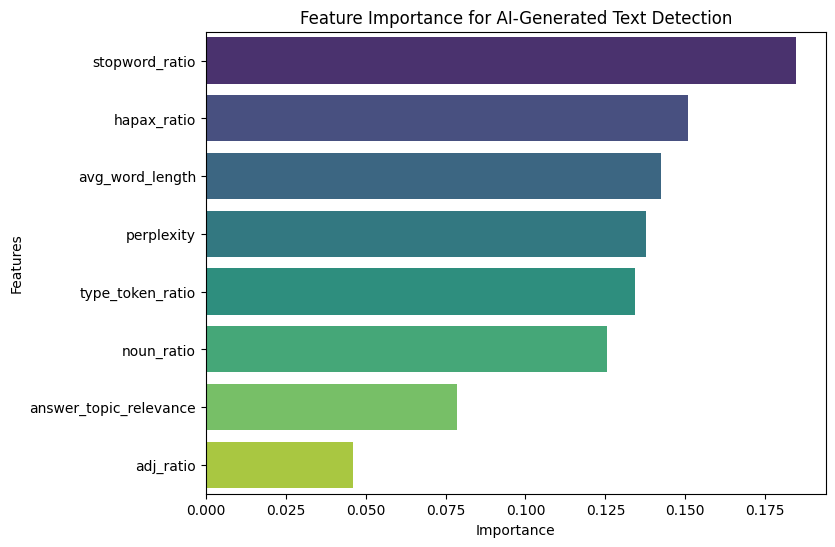

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Select high-correlation features
features = [
    "avg_word_length",
    "stopword_ratio",
    "noun_ratio",
    "type_token_ratio",
    "adj_ratio",
    "perplexity",
    "hapax_ratio",
    "answer_topic_relevance"
]

X = train_df[features]
y = train_df["is_cheating"]

# 2️⃣ Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

# 3️⃣ Get feature importances
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

# 4️⃣ Plot feature importances
plt.figure(figsize=(8,6))
sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")
plt.title("Feature Importance for AI-Generated Text Detection")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:06:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:06:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:06:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


Fold 1 AUC: 0.9139
Fold 2 AUC: 0.9944
Fold 3 AUC: 0.9490


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:06:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [19:06:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


Fold 4 AUC: 0.9352
Fold 5 AUC: 0.9282

✅ Mean CV ROC–AUC: 0.9441


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:06:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Submission saved as 'submission_xgb_prob.csv' — contains probabilities only!


/tmp/ipython-input-2986285565.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")


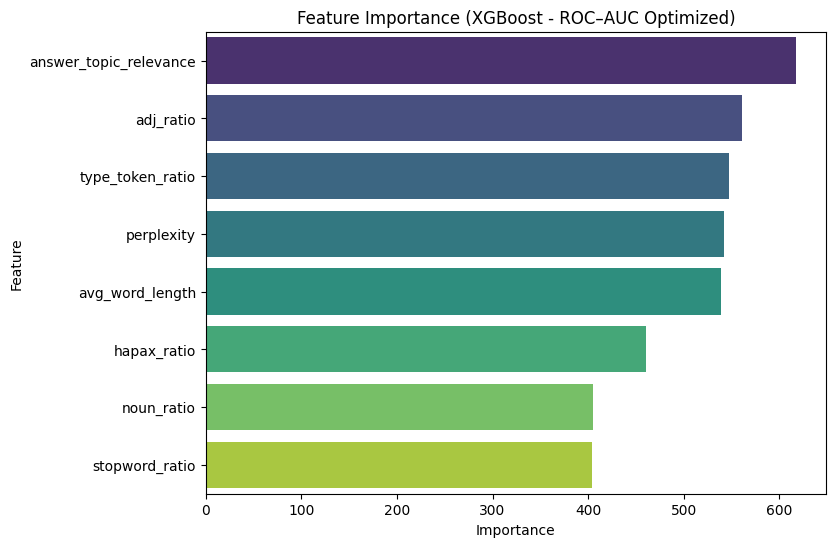

In [ ]:
# 📦 Imports
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 1: Select features
features = [
    "avg_word_length",
    "stopword_ratio",
    "noun_ratio",
    "type_token_ratio",
    "adj_ratio",
    "perplexity",
    "hapax_ratio",
    "answer_topic_relevance"
]

X_train = train_df[features]
y_train = train_df["is_cheating"]
X_test = test_df[features]

# ✅ Step 2: XGBoost parameters optimized for ROC-AUC
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.04,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_estimators": 1000
}

# ✅ Step 3: Cross-validation using DMatrix (works in XGBoost 3.x)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    evals = [(dtrain, "train"), (dval, "val")]

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=100,
        verbose_eval=False
    )

    val_pred = model.predict(dval)
    auc = roc_auc_score(y_val, val_pred)
    auc_scores.append(auc)
    print(f"Fold {fold+1} AUC: {auc:.4f}")

print(f"\n✅ Mean CV ROC–AUC: {sum(auc_scores)/len(auc_scores):.4f}")

# ✅ Step 4: Train final model on full data
dtrain_full = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

final_model = xgb.train(
    params,
    dtrain_full,
    num_boost_round=1000
)

# ✅ Step 5: Predict probabilities
test_df["is_cheating"] = final_model.predict(dtest)

# ✅ Step 6: Save submission
submission = test_df[["id", "is_cheating"]]
submission.to_csv("submission_xgb_prob_with_relevance.csv", index=False)
print("✅ Submission saved as 'submission_xgb_prob.csv' — contains probabilities only!")

# ✅ Step 7: Feature importance plot
importance = final_model.get_score(importance_type="weight")
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance (XGBoost - ROC–AUC Optimized)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.2 MB/s eta 0:00:00


In [ ]:
# --------------------------------------------------------------
# 1. PREPARE DATA (keep exactly what you already have)
# --------------------------------------------------------------
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna                     # <-- pip install optuna
import warnings
warnings.filterwarnings('ignore')

features = [
    "avg_word_length", "stopword_ratio", "noun_ratio",
    "type_token_ratio", "adj_ratio", "perplexity", "hapax_ratio","answer_topic_relevance"
]

X = train_df[features].copy()
y = train_df["is_cheating"].copy()

# --------------------------------------------------------------
# 2. OPTIONAL: class-weight (helps when cheating is rare)
# --------------------------------------------------------------
pos_weight = (y == 0).sum() / (y == 1).sum()   # scale_pos_weight = neg/pos
print(f"scale_pos_weight ≈ {pos_weight:.2f}")

# --------------------------------------------------------------
# 3. OPTUNA OBJECTIVE (runs a 5-fold CV inside each trial)
# --------------------------------------------------------------
def objective(trial):
    param_grid = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",               # fast & memory-efficient
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "scale_pos_weight": pos_weight,
        "random_state": 42,
    }

    n_estimators = trial.suggest_int("n_estimators", 200, 3000)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_aucs = []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval   = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(
            param_grid,
            dtrain,
            num_boost_round=n_estimators,
            evals=[(dval, "val")],
            early_stopping_rounds=150,
            verbose_eval=False,
        )

        preds = model.predict(dval)
        cv_aucs.append(roc_auc_score(y_val, preds))

    return np.mean(cv_aucs)

# --------------------------------------------------------------
# 4. RUN OPTUNA optimisation (≈ 30–60 min on a laptop)
# --------------------------------------------------------------
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=20)
)
study.optimize(objective, n_trials=80, timeout=None)   # increase trials for more gain

print("\nBest trial:")
print(study.best_trial.params)
print(f"Best CV AUC: {study.best_value:.5f}")

# --------------------------------------------------------------
# 5. RETRAIN FINAL MODEL with the best params + early stopping
# --------------------------------------------------------------
best_params = study.best_trial.params.copy()
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "scale_pos_weight": pos_weight,
    "random_state": 42,
})

dtrain_full = xgb.DMatrix(X, label=y)
dtest       = xgb.DMatrix(test_df[features])

final_model = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=10_000,          # large enough – early stopping will stop
    evals=[(dtrain_full, "train")],
    early_stopping_rounds=200,
    verbose_eval=False,
)

# --------------------------------------------------------------
# 6. TEST-SET PREDICTION
# --------------------------------------------------------------
test_pred = final_model.predict(dtest)
print(f"\nTest AUC (if you have labels): {roc_auc_score(test_df['is_cheating'], test_pred):.5f}")

[I 2025-10-28 19:07:18,104] A new study created in memory with name: no-name-871ec9d6-4b01-4a79-a20b-eb2365154e2c


scale_pos_weight ≈ 0.83


[I 2025-10-28 19:07:18,333] Trial 0 finished with value: 0.9046963601532567 and parameters: {'learning_rate': 0.008468008575248327, 'max_depth': 10, 'min_child_weight': 14.907884894416696, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 2.5348407664333426e-07, 'reg_lambda': 3.3323645788192616e-08, 'n_estimators': 2626}. Best is trial 0 with value: 0.9046963601532567.
[I 2025-10-28 19:07:18,853] Trial 1 finished with value: 0.9418007662835249 and parameters: {'learning_rate': 0.030834348179355788, 'max_depth': 8, 'min_child_weight': 1.3911053916202465, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'reg_alpha': 8.148018307012941e-07, 'reg_lambda': 4.329370014459266e-07, 'n_estimators': 713}. Best is trial 1 with value: 0.9418007662835249.
[I 2025-10-28 19:07:19,157] Trial 2 finished with value: 0.9090277777777779 and parameters: {'learning_rate': 0.005670807781371429, 'max_depth': 7, 'min_child_weight': 9.206955354200199, '


Best trial:
{'learning_rate': 0.189648504247573, 'max_depth': 4, 'min_child_weight': 1.0496971859295177, 'subsample': 0.7200387051717209, 'colsample_bytree': 0.7636449342162019, 'reg_alpha': 4.377563276154519e-05, 'reg_lambda': 0.006612313320666433, 'n_estimators': 1462}
Best CV AUC: 0.94744


ValueError: continuous format is not supported

In [ ]:
# --------------------------------------------------------------
# 1. IMPORTS
# --------------------------------------------------------------
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import roc_auc_score

# --------------------------------------------------------------
# 2. DATA (ensure train_df and test_df are loaded)
# --------------------------------------------------------------
# train_df: has features + "is_cheating"
# test_df:  has features + "id" (no label)

features = [
    "avg_word_length", "stopword_ratio", "noun_ratio",
    "type_token_ratio", "adj_ratio", "perplexity", "hapax_ratio","answer_topic_relevance"
]

X_train = train_df[features].copy()
y_train = train_df["is_cheating"].copy()
X_test  = test_df[features].copy()

# --------------------------------------------------------------
# 3. SCALE POS WEIGHT (for class imbalance)
# --------------------------------------------------------------
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
print(f"Class balance → Negative: {neg_count}, Positive: {pos_count}")
print(f"scale_pos_weight = {scale_pos_weight:.3f}")

# --------------------------------------------------------------
# 4. BEST HYPERPARAMETERS FROM OPTUNA
# --------------------------------------------------------------


best_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "learning_rate": 0.189648504247573,
    "max_depth": 4,
    "min_child_weight": 1.0496971859295177,
    "subsample": 0.7200387051717209,
    "colsample_bytree": 0.7636449342162019,
    "reg_alpha": 4.377563276154519e-05,
    "reg_lambda": 0.006612313320666433,
    "scale_pos_weight": scale_pos_weight,
    "random_state": 42,
    "verbosity": 0,
}

n_estimators = 1462  # from Optuna best trial

# --------------------------------------------------------------
# 5. TRAIN ON FULL TRAINING DATA
# --------------------------------------------------------------
dtrain_full = xgb.DMatrix(X_train, label=y_train)
dtest       = xgb.DMatrix(X_test)

print("Training final model on full training data...")
final_model = xgb.train(
    params=best_params,
    dtrain=dtrain_full,
    num_boost_round=n_estimators
)

# --------------------------------------------------------------
# 6. PREDICT PROBABILITIES ON TEST SET
# --------------------------------------------------------------
print("Predicting probabilities on test set...")
test_pred_proba = final_model.predict(dtest)  # Probability of is_cheating == 1 (AI-generated)

# --------------------------------------------------------------
# 7. CREATE SUBMISSION FILE
# --------------------------------------------------------------
submission = pd.DataFrame({
    "id": test_df["id"],                     # make sure 'id' column exists
    "is_cheating": test_pred_proba
})

# Optional: round to 6 decimals
submission["is_cheating"] = submission["is_cheating"].round(6)

# Save
submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)
print(f"\nSubmission saved to: {submission_path}")
print(submission.head())

Class balance → Negative: 122, Positive: 147
scale_pos_weight = 0.830
Training final model on full training data...
Predicting probabilities on test set...

Submission saved to: submission.csv
                 id  is_cheating
0  scr_81822029c661     0.351386
1  scr_52efb19e0ea9     0.999814
2  scr_8fc0f33c559e     0.090187
3  scr_bac3f5d3aa12     0.013720
4  scr_adfbe009984d     0.000206


In [ ]:
df = pd.read_csv("/content/submission.csv")

In [ ]:
df.head()

,id,is_cheating
0,scr_81822029c661,0.388830
1,scr_52efb19e0ea9,0.999776
2,scr_8fc0f33c559e,0.068651
3,scr_bac3f5d3aa12,0.099268
4,scr_adfbe009984d,0.000501


In [ ]:
df = df.rename(columns={"predicted_probability": "is_cheating"})

In [ ]:
df.to_csv("submission_xgb.csv")

# Analysis on Two Submission Files

In [ ]:
sub1 = pd.read_csv("/content/submission_xgb_prob_with_relevance.csv")
sub2 = pd.read_csv("/content/submission.csv")

# Ensure same id order
merged = sub1.merge(sub2, on="id", suffixes=("_1", "_2"))
merged.head()

,id,is_cheating_1,is_cheating_2
0,scr_81822029c661,0.522240,0.351386
1,scr_52efb19e0ea9,0.999671,0.999814
2,scr_8fc0f33c559e,0.070467,0.090187
3,scr_bac3f5d3aa12,0.008956,0.013720
4,scr_adfbe009984d,0.001965,0.000206


In [ ]:
corr = merged["is_cheating_1"].corr(merged["is_cheating_2"])
print(f"Correlation between submissions: {corr:.4f}")

# Absolute difference
merged["abs_diff"] = (merged["is_cheating_1"] - merged["is_cheating_2"]).abs()

print("Mean absolute difference:", merged["abs_diff"].mean())
print("Samples with <0.01 difference:", (merged["abs_diff"] < 0.01).mean())

Correlation between submissions: 0.9827
Mean absolute difference: 0.03761401999734849
Samples with <0.01 difference: 0.6287878787878788


In [ ]:
def label_confidence(p):
    if p >= 0.9: return "Very likely cheating"
    elif p >= 0.7: return "Likely cheating"
    elif p >= 0.5: return "Uncertain"
    elif p >= 0.3: return "Likely human"
    else: return "Very likely human"

merged["label_1"] = merged["is_cheating_1"].apply(label_confidence)
merged["label_2"] = merged["is_cheating_2"].apply(label_confidence)

# Agreement summary
agreement = (merged["label_1"] == merged["label_2"]).mean()
print(f"Label agreement: {agreement:.2%}")

Label agreement: 86.74%


In [ ]:
high_confident_ai = merged[(merged["is_cheating_1"] > 0.99) & (merged["is_cheating_2"] > 0.99)]
print(f"Count of strongly agreed cheating samples: {len(high_confident_ai)}")

# Optional: mark them
merged["final_pred"] = merged.apply(
    lambda x: 1 if (x["is_cheating_1"] > 0.99 and x["is_cheating_2"] > 0.99) else 0, axis=1
)

Count of strongly agreed cheating samples: 87


In [ ]:
merged["final_pred_0.9"] = merged.apply(
    lambda x: 1 if (x["is_cheating_1"] > 0.9 and x["is_cheating_2"] > 0.9) else 0, axis=1
)

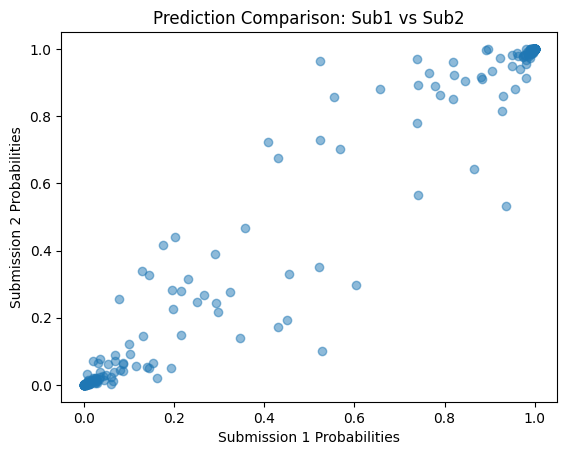

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(merged["is_cheating_1"], merged["is_cheating_2"], alpha=0.5)
plt.xlabel("Submission 1 Probabilities")
plt.ylabel("Submission 2 Probabilities")
plt.title("Prediction Comparison: Sub1 vs Sub2")
plt.show()

In [ ]:
merged["is_cheating"] = (merged["is_cheating_1"] * 0.5 + merged["is_cheating_2"] * 0.5)
merged[["id", "is_cheating"]].to_csv("final_blend.csv", index=False)

In [ ]:
merged.head()

,id,is_cheating_1,is_cheating_2,abs_diff,label_1,label_2,final_pred,final_pred_0.9,is_cheating
0,scr_81822029c661,0.522240,0.351386,0.170854,Uncertain,Likely human,0,0,0.436813
1,scr_52efb19e0ea9,0.999671,0.999814,0.000143,Very likely cheating,Very likely cheating,1,1,0.999743
2,scr_8fc0f33c559e,0.070467,0.090187,0.019720,Very likely human,Very likely human,0,0,0.080327
3,scr_bac3f5d3aa12,0.008956,0.013720,0.004764,Very likely human,Very likely human,0,0,0.011338
4,scr_adfbe009984d,0.001965,0.000206,0.001759,Very likely human,Very likely human,0,0,0.001086


In [ ]:
# Keep only required columns
final_submission = merged[["id", "is_cheating"]]

# Save to CSV
final_submission.to_csv("submission_merged.csv", index=False)